# 🚜Predicting the Sale Price of Bull dozers using Machine Learning

In this notebook, we're going to go through an example machine learning project with the goal of predicting the sale price of bulldozers

## 1. Problem Definition

> How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?

## 2. Data

Data is downloaded from Kaggle Bluebook for Bulldozers competition:

The data for this competition is split into three parts:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check:
https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

**Note:** The goal for most regression evaluation metrics is to minize the error. For example, our goal for this project will be to build a machine learning model which minimises RMSLE.

## 4. Features

Kaggle provides a data dictionary detialing all of the features of the dataset. You can view this data dictionary on google sheets:
https://docs.google.com/spreadsheets/d/1xOci34bLORWspWuVU68KQxHRGpKHO8eYKNstPwjbLpI/edit#gid=641893559

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [2]:
# Import training and validation sets
df = pd.read_csv("data/bulldozer-pp/TrainAndValid.csv",
                 low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [4]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

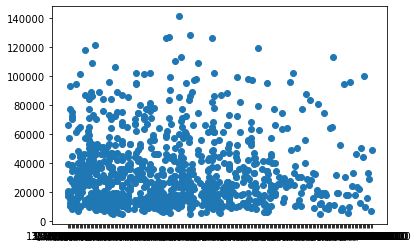

In [5]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

In [6]:
df.saledate[:1000]

0      11/16/2006 0:00
1       3/26/2004 0:00
2       2/26/2004 0:00
3       5/19/2011 0:00
4       7/23/2009 0:00
            ...       
995     7/16/2009 0:00
996     6/14/2007 0:00
997     9/22/2005 0:00
998     7/28/2005 0:00
999     6/16/2011 0:00
Name: saledate, Length: 1000, dtype: object

<AxesSubplot:ylabel='Frequency'>

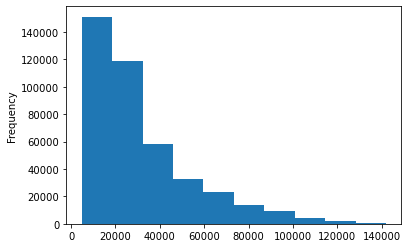

In [7]:
df.SalePrice.plot.hist()

# Parsing Dates

When we work with time series data, we want to enrich the time & date component as much as possible. 
We can do that by telling pandas which of our columns has dates in it using the `parse_date` parameter.

In [8]:
# Impor t Data again but this time parse dates
df = pd.read_csv("data/bulldozer-pp/TrainAndValid.csv",
                 low_memory= False,
                 parse_dates=["saledate"])

In [9]:
df.saledate.dtype

dtype('<M8[ns]')

In [10]:
df.saledate[:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

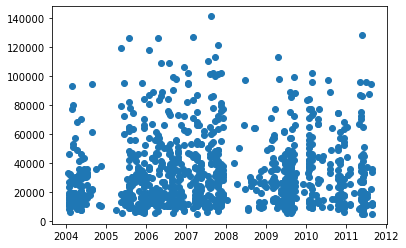

In [11]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

In [12]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [14]:
df.saledate.head(20)

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

## Sort DataFrame by saledate

When working with time series data, it's a good idea to sort it by date.

In [15]:
# Sort DataFrame in date order
df.sort_values(by=["saledate"], inplace=True, ascending=True)
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

## Make a copy of the original DataFrame

We make a copy of the original dataframe so when we manipulate the copy, we've still got out original data.

In [16]:
# Make a copy
df_tmp = df.copy()

## Add Datetime parameters for `saledate` column

In [17]:
df_tmp["saleyear"] = df_tmp.saledate.dt.year
df_tmp["salemonth"] = df_tmp.saledate.dt.month
df_tmp["saleday"] = df_tmp.saledate.dt.day
df_tmp["saledayofweek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saledayofyear"] = df_tmp.saledate.dt.dayofyear


In [18]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [19]:
# Now we've enriched our DataFrame with date time features, we can move saledate
df_tmp.drop("saledate", axis=1, inplace=True)

In [20]:
df_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

In [21]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleyear,salemonth,saleday,saledayofweek,saledayofyear
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,...,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1,31


# 5. Modelling

We've done enough EDA(we could always do more) but let's start to do some model-driven EDA

In [22]:
# let's build a machine learning model
# from sklearn.ensemble import RandomForestRegressor

# model = RandomForestRegressor(n_jobs = -1,
#                               random_state=42)
# model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"])

In [23]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-nul

In [24]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

### Convert String to Categories

One way we can turn all of our data into numbers is by converting them into pandas categories.

we can check the different datatypes compatible with pandas here:
https://pandas.pydata.org/docs/reference/general_utility_functions.html

In [25]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [26]:
pd.api.types.is_string_dtype(df_tmp["UsageBand"])

True

In [27]:
# Find the columns which contains strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [28]:
# This will turn all of the string value into category values
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered() 
        # when we do this we assign a numerical value to each object
        # Under the hood pandas is treating these as numbers

In [29]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [30]:
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [31]:
df_tmp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

Thanks to pandas Categories we now have a way to access all of our data in the form of numbers.

But we still have a bunch of missing data...

In [32]:
# Check missing data
df_tmp.isnull().sum()/len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

### Save the processed data

In [33]:
# Export current tmp dataframe
df_tmp.to_csv("data/bulldozer-pp/train_tmp.csv",
              index=False)

In [34]:
# Import preprocessed data
df_tmp = pd.read_csv("data/bulldozer-pp/train_tmp.csv",
                     low_memory=False)
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


### Fill the numeric values first

In [35]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleyear
salemonth
saleday
saledayofweek
saledayofyear


In [36]:
df_tmp.ModelID

0          8434
1         10150
2          4139
3          8591
4          4089
          ...  
412693     5266
412694    19330
412695    17244
412696     3357
412697     4701
Name: ModelID, Length: 412698, dtype: int64

In [37]:
# Check for which numeric clomns have null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [38]:
# Fill numeric rows with the median
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells us if the data was missing
            df_tmp[label+ "_is_missing"]= pd.isnull(content)
            
            df_tmp[label] = content.fillna(content.median())

In [39]:
# We choose median over mean because its more robust
hundreds = np.full((1000,), 100)
hundreds_billion = np.append(hundreds, 1000000000)
np.mean(hundreds), np.mean(hundreds_billion), np.median(hundreds), np.median(hundreds_billion)

(100.0, 999100.8991008991, 100.0, 100.0)

In [40]:
# Check if there's any null numeric values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [41]:
# Check to see how many examples were missing
df_tmp.auctioneerID_is_missing.value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

In [42]:
df_tmp.isna().sum()

SalesID                                     0
SalePrice                                   0
MachineID                                   0
ModelID                                     0
datasource                                  0
auctioneerID                                0
YearMade                                    0
MachineHoursCurrentMeter                    0
UsageBand                              339028
fiModelDesc                                 0
fiBaseModel                                 0
fiSecondaryDesc                        140727
fiModelSeries                          354031
fiModelDescriptor                      337882
ProductSize                            216605
fiProductClassDesc                          0
state                                       0
ProductGroup                                0
ProductGroupDesc                            0
Drive_System                           305611
Enclosure                                 334
Forks                             

### Filling and turning categorical variables into numbers 

In [43]:
# Check for columns which aren't numeric
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)  

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [44]:
# Turn categorical variables into numbers and fill missing
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        df_tmp[label+"is_missing_"]= pd.isnull(content)
        df_tmp[label] = pd.Categorical(content).codes+1

In [45]:
pd.Categorical(df_tmp["state"]).codes

array([43,  8,  8, ...,  4,  4,  4], dtype=int8)

In [46]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 103 entries, SalesID to Steering_Controlsis_missing_
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 77.9 MB


In [47]:
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mountingis_missing_,False,True,False,True,False
Blade_Typeis_missing_,False,True,False,True,False
Travel_Controlsis_missing_,False,True,False,True,False
Differential_Typeis_missing_,True,False,True,False,True


In [48]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mountingis_missing_     0
Blade_Typeis_missing_           0
Travel_Controlsis_missing_      0
Differential_Typeis_missing_    0
Steering_Controlsis_missing_    0
Length: 103, dtype: int64

Now that all of dat ais numeric as well as oour datframe has no missing values, we should be able to build a machine learning model.

In [49]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Widthis_missing_,Stick_Lengthis_missing_,Thumbis_missing_,Pattern_Changeris_missing_,Grouser_Typeis_missing_,Backhoe_Mountingis_missing_,Blade_Typeis_missing_,Travel_Controlsis_missing_,Differential_Typeis_missing_,Steering_Controlsis_missing_
0,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,True,True,True,True,True,False,False,False,True,True
1,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,...,True,True,True,True,True,True,True,True,False,False
2,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,...,True,True,True,True,True,False,False,False,True,True
3,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,...,True,True,True,True,True,True,True,True,False,False
4,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,...,True,True,True,True,True,False,False,False,True,True


In [50]:
len(df_tmp)

412698

In [51]:
%%time 
from sklearn.ensemble import RandomForestRegressor
# Instantiate model 
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42)

#Fit the model
model.fit(df_tmp.drop("SalePrice", axis= 1), df_tmp["SalePrice"])

Wall time: 2min 33s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [52]:
#Score the model 
model.score(df_tmp.drop("SalePrice", axis= 1), df_tmp["SalePrice"])

0.9875468079970562

**Question:** Even with this much acc why isn't it reliable?

**Ans:** Because the model has tested itself on trained data itself

### Splitting data into train/Validation sets

In [53]:
df_tmp.saleyear

0         1989
1         1989
2         1989
3         1989
4         1989
          ... 
412693    2012
412694    2012
412695    2012
412696    2012
412697    2012
Name: saleyear, Length: 412698, dtype: int64

In [54]:
df_tmp.saleyear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleyear, dtype: int64

In [55]:
# Split data into training and validation 
df_val = df_tmp[df_tmp.saleyear == 2012]
df_train = df_tmp[df_tmp.saleyear != 2012]

len(df_val), len(df_train)

(11573, 401125)

In [56]:
# Split data into x and y
x_train, y_train = df_train.drop("SalePrice", axis= 1), df_train["SalePrice"]
x_valid, y_valid = df_val.drop("SalePrice", axis= 1), df_val["SalePrice"]

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

In the previous few videos we worked on filling the missing data in the training and validation data before splitting it into training and validation sets using the following code:

# Split data into training and validation
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

The code worked but how might this interfere with our model?

Remember the goal of machine learning: use the past to predict the future.

So if our validation set is supposed to be representative of the future and we’re filling our training data using information from the validation set, what might this mean for our model?

The challenge here comes in two parts.

What does it mean if we fill our training data with information from the future (validation set)?

How might you implement a fix to the current way things are being done in the project?

If you need a hint, remember some takeaways from a previous lecture:

Split your data first (into train/test), always keep your training & test data separate

Fill/transform the training set and test sets separately (this goes for filling data with pandas as well)

Don’t use data from the future (test set) to fill data from the past (training set)

Keep these things in mind when we create a data preprocessing function in a few videos time, they'll help you answer the question which gets raised then too.

In [57]:
# Create evaluation function (the competition uses RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    """
    Calculates root mean squared log error between predictions and true lables.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate model on a few different levels
def show_scores(model):
    train_preds = model.predict(x_train)
    val_preds = model.predict(x_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": r2_score(y_train, train_preds),
              "Valid R^2": r2_score(y_valid, val_preds)}
    return scores

# Testing our model on a subset (to tune the hyperparameters)

In [58]:
# Change max_samples values
model = RandomForestRegressor(n_jobs=-1,
                              random_state= 42,
                              max_samples= 10000)

model

RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [59]:
%%time
# Cutting down on the max number of samples each estimator can see 
model.fit(x_train, y_train)

Wall time: 6.95 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [60]:
show_scores(model)

{'Training MAE': 5561.2988092240585,
 'Valid MAE': 7177.26365505919,
 'Training RMSLE': 0.257745378256977,
 'Valid RMSLE': 0.29362638671089003,
 'Training R^2': 0.8606658995199189,
 'Valid R^2': 0.8320374995090507}

# Hyperparameter tuning with RandomizedSearchCV

In [61]:
%%time 
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid = {"n_estimators": np.arange(10,100,10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2,20,2),
           "min_samples_leaf": np.arange(1,20,2),
           "max_features": [0.5, 1, "squrt", "auto"],
           "max_samples": [10000]}



rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                   random_state=42),
                             param_distributions=rf_grid,
                             n_iter = 5,
                             cv = 5,
                             verbose=True)

# Fit the RandomizedSearchCV Model
rs_model.fit(x_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Users\Prathamesh Parit\Desktop\bulldozer-project\env\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\Prathamesh Parit\Desktop\bulldozer-project\env\lib\site-packages\joblib\externals\loky\process_executor.py", line 436, in _process_worker
    r = call_item()
  File "C:\Users\Prathamesh Parit\Desktop\bulldozer-project\env\lib\site-packages\joblib\externals\loky\process_executor.py", line 288, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "C:\Users\Pra

Wall time: 2min 4s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=5,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'squrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [62]:
show_scores(rs_model)

{'Training MAE': 6918.7034825600795,
 'Valid MAE': 8021.452551617654,
 'Training RMSLE': 0.3079134083511872,
 'Valid RMSLE': 0.3240367281783524,
 'Training R^2': 0.7968986873699622,
 'Valid R^2': 0.7972499368446146}

## Train a model with the best hyperparameters
**Note:** These were found after 100 iterations of `RandomizedSearchCV`

In [63]:
%%time 

# Most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    random_state=42)

# Fit the ideal model
ideal_model.fit(x_train, y_train)

Wall time: 33.2 s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1, random_state=42)

In [64]:
# Scores for Ideal_model (trainned on all the data)
show_scores(ideal_model)

{'Training MAE': 2953.8161137163484,
 'Valid MAE': 5951.247761444453,
 'Training RMSLE': 0.14469006962371858,
 'Valid RMSLE': 0.2452416398953833,
 'Training R^2': 0.9588145522577225,
 'Valid R^2': 0.8818019502450094}

In [65]:
# Score on rs_model
show_scores(rs_model)

{'Training MAE': 6918.7034825600795,
 'Valid MAE': 8021.452551617654,
 'Training RMSLE': 0.3079134083511872,
 'Valid RMSLE': 0.3240367281783524,
 'Training R^2': 0.7968986873699622,
 'Valid R^2': 0.7972499368446146}

# Make predictions on test data

In [66]:
# import the test data
df_test = pd.read_csv("data/bulldozer-pp/Test.csv",
                      low_memory=False,
                      parse_dates=["saledate"])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [67]:
# # Make preidictions on the test dataset
# test_preds = ideal_model.predict(df_test)
# Error

# Preprossessing the data (getting the test dataset in the same format os format as our training dataset)


In [68]:
def preprocessed_data(df):
    """
    Performs transformations on df and  returns transformed df.
    """
    df["saleyear"] = df.saledate.dt.year
    df["salemonth"] = df.saledate.dt.month
    df["saleday"] = df.saledate.dt.day
    df["saledayofweek"] = df.saledate.dt.dayofweek
    df["saledayofyear"] = df.saledate.dt.dayofyear
    
    df.drop("saledate", axis=1, inplace=True)
    
    # Fill numeric rows with the median
    for label, content in df .items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column which tells us if the data was missing
                df[label+ "_is_missing"]= pd.isnull(content)

                df[label] = content.fillna(content.median())
    
    # Turn categorical variables into numbers and fill missing
    for label, content in df.items():
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"is_missing_"]= pd.isnull(content)
            df[label] = pd.Categorical(content).codes+1
    
    return df

In [69]:
# Process the ttest data
df_test = preprocessed_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Widthis_missing_,Stick_Lengthis_missing_,Thumbis_missing_,Pattern_Changeris_missing_,Grouser_Typeis_missing_,Backhoe_Mountingis_missing_,Blade_Typeis_missing_,Travel_Controlsis_missing_,Differential_Typeis_missing_,Steering_Controlsis_missing_
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [70]:
x_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Widthis_missing_,Stick_Lengthis_missing_,Thumbis_missing_,Pattern_Changeris_missing_,Grouser_Typeis_missing_,Backhoe_Mountingis_missing_,Blade_Typeis_missing_,Travel_Controlsis_missing_,Differential_Typeis_missing_,Steering_Controlsis_missing_
0,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
1,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,True,True,True,True,True,True,True,True,False,False
2,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,True,True,True,True,True,False,False,False,True,True
3,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,True,True,True,True,True,True,True,True,False,False
4,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,...,True,True,True,True,True,False,False,False,True,True


In [71]:
# We can find how the columns differ using sets
set(x_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In [72]:
# Manually adjust df_test to have auctioneerID_is_missing column
df_test["acutioneerID_is_missing"] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Lengthis_missing_,Thumbis_missing_,Pattern_Changeris_missing_,Grouser_Typeis_missing_,Backhoe_Mountingis_missing_,Blade_Typeis_missing_,Travel_Controlsis_missing_,Differential_Typeis_missing_,Steering_Controlsis_missing_,acutioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


Finally now our test dataframe hasd the same features as our training dataframe, we can make predictions!

In [73]:
# Make predictions on the test data
test_preds = ideal_model.predict(df_test)
test_preds

C:\Users\Prathamesh Parit\Desktop\bulldozer-project\env\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- acutioneerID_is_missing
Feature names seen at fit time, yet now missing:
- auctioneerID_is_missing

  warnings.warn(message, FutureWarning)


array([20614.36780887, 19897.80170658, 44852.21959446, ...,
       14296.98620472, 22164.85757662, 31683.80063427])

We've made some predictions but they're not in the same format Kaggle is asking for:

In [74]:
# Format predictions into the same format Kaggle is after
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds

In [75]:
df_preds

,SalesID,SalesPrice
0,1227829,20614.367809
1,1227844,19897.801707
2,1227847,44852.219594
3,1227848,68346.325323
4,1227863,39487.349708
...,...,...
12452,6643171,46466.092910
12453,6643173,17500.493352
12454,6643184,14296.986205
12455,6643186,22164.857577


In [76]:
# Export prediction data
df_preds.to_csv("data/bulldozer-pp/test_predictions.csv", index= False)

# Feature Importance 

Feature importance seeks to figure out which different attributes of the data were most important when it comes to predcitiing the target variable(SalePrice)

In [77]:
# Find feature Imortance of our best model
len(ideal_model.feature_importances_)

102

In [78]:
x_train

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Widthis_missing_,Stick_Lengthis_missing_,Thumbis_missing_,Pattern_Changeris_missing_,Grouser_Typeis_missing_,Backhoe_Mountingis_missing_,Blade_Typeis_missing_,Travel_Controlsis_missing_,Differential_Typeis_missing_,Steering_Controlsis_missing_
0,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
1,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,True,True,True,True,True,True,True,True,False,False
2,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,True,True,True,True,True,False,False,False,True,True
3,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,True,True,True,True,True,True,True,True,False,False
4,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,...,True,True,True,True,True,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,6260687,1074871,4331,149,2.0,1000,0.0,0,3137,1055,...,True,True,True,True,True,True,True,True,False,False
401121,6312170,1812622,9580,149,2.0,2005,0.0,0,4514,1684,...,True,True,True,True,True,True,True,True,True,True
401122,6312727,1811599,9580,149,2.0,2005,0.0,0,4514,1684,...,True,True,True,True,True,True,True,True,True,True
401123,6315051,1858173,17432,149,2.0,2004,0.0,0,3389,1175,...,True,True,True,True,True,True,True,True,True,True


In [81]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df= (pd.DataFrame({"features": columns,
                       "feature_importances": importances})
         .sort_values("feature_importances", ascending=False)
         .reset_index(drop=True))
    
    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Features Importance")
    ax.invert_yaxis()

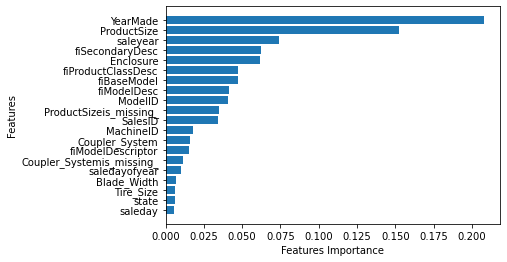

In [82]:
plot_features(x_train.columns, ideal_model.feature_importances_)

**Question to finish:** Why might knowing the feature importances of a trained machine learning model be helpful?

**Final Challenge:** What other machine learning models could you try on our dataset?
the Regression section of this map, or try to look at something like CatBoost.ai or XGBoost.ai.